# **Preparação dos dados**

In [ ]:
import os

# Upload do arquivo .tar.gz baixado do link acima
from google.colab import files
print("📁 Faça o upload do arquivo all-mias.tar.gz (baixe de http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz)")
uploaded = files.upload()

# Listar os arquivos enviados no diretório atual
print("📂 Arquivos disponíveis no /content:")
for file in os.listdir("/content"):
    print("-", file)

📁 Faça o upload do arquivo all-mias.tar.gz (baixe de http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz)


Saving allmias.tar.gz to allmias.tar.gz
📂 Arquivos disponíveis no /content:
- .config
- allmias.tar.gz
- sample_data


 Arquivo renomeado: allmias.tar.gz → all-mias.tar.gz
 Extraindo conteúdo...


/tmp/ipython-input-1149642565.py:28: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=base_path)


 Total de imagens encontradas: 322


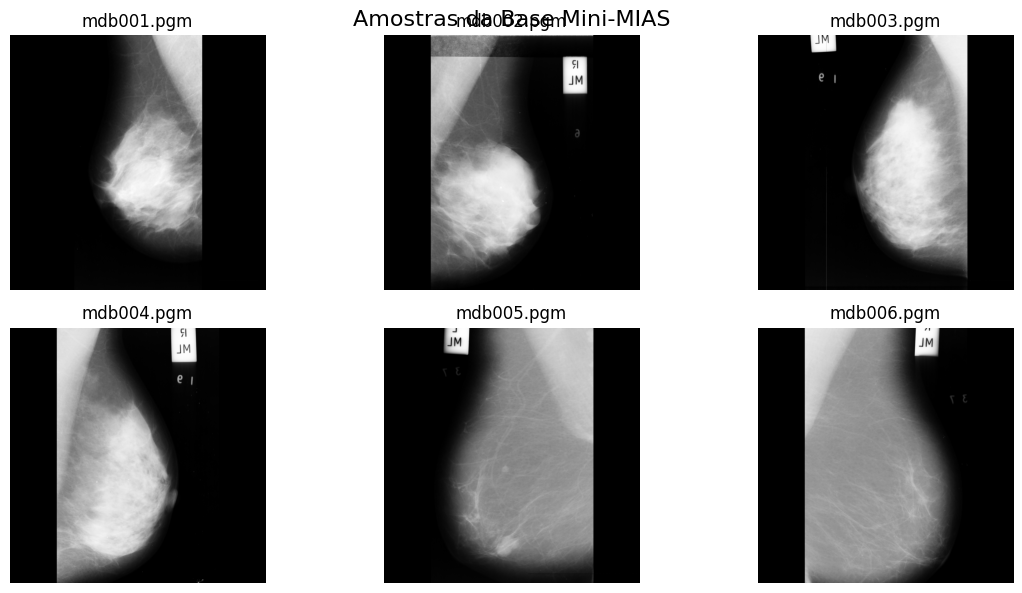


 Estatísticas das imagens:
- Dimensões únicas: [[1024 1024]]
- Média altura: 1024.00px | Média largura: 1024.00px

 Lendo Info.txt...
  filename tissue abnormality severity    x    y  radius
0   mdb001      G        CIRC        B  535  425     197
1   mdb002      G        CIRC        B  522  280      69
2   mdb003      D        NORM   normal    0    0       0
3   mdb004      D        NORM   normal    0    0       0
4   mdb005      F        CIRC        B  477  133      30

Total de registros processados: 330

 Distribuição das classes (abnormality):
abnormality
NORM    207
CALC     30
CIRC     25
SPIC     19
ARCH     19
MISC     15
ASYM     15
Name: count, dtype: int64

 Distribuição da severidade (severity):
severity
normal    207
B          69
M          54
Name: count, dtype: int64

 Resumo:


,Tipo de imagem,Quantidade
0,Normais,207
1,Com anormalidade,123
2,Total,330


      filename severity  label
0   mdb001.pgm        B      1
1   mdb002.pgm        B      1
2   mdb003.pgm   normal      0
3   mdb004.pgm   normal      0
4   mdb005.pgm        B      1
5   mdb005.pgm        B      1
6   mdb006.pgm   normal      0
7   mdb007.pgm   normal      0
8   mdb008.pgm   normal      0
9   mdb009.pgm   normal      0
10  mdb010.pgm        B      1
11  mdb011.pgm   normal      0
12  mdb012.pgm        B      1
13  mdb013.pgm        B      1
14  mdb014.pgm   normal      0


In [ ]:
# =====================================================
#  IMPORTAÇÕES INICIAIS
# =====================================================
import os
import tarfile
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# =====================================================
#  ETAPA 1: EXTRAÇÃO E LEITURA DOS DADOS
# =====================================================
base_path = "./mini-mias"
os.makedirs(base_path, exist_ok=True)

# Renomear o arquivo .tar.gz (caso necessário)
for file in os.listdir("."):
    if file.endswith(".tar.gz"):
        os.rename(file, "all-mias.tar.gz")
        print(f" Arquivo renomeado: {file} → all-mias.tar.gz")
        break

# Extrair conteúdo
print(" Extraindo conteúdo...")
with tarfile.open("all-mias.tar.gz", "r:gz") as tar:
    tar.extractall(path=base_path)

# Listar imagens
pgm_files = sorted([f for f in os.listdir(base_path) if f.endswith(".pgm")])
print(f" Total de imagens encontradas: {len(pgm_files)}")

# Mostrar amostras
plt.figure(figsize=(12, 6))
for i, file in enumerate(pgm_files[:6]):
    img = cv2.imread(os.path.join(base_path, file), cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(file)
    plt.axis("off")
plt.tight_layout()
plt.suptitle("Amostras da Base Mini-MIAS", fontsize=16)
plt.show()

# Estatísticas das dimensões
shapes = [cv2.imread(os.path.join(base_path, f), cv2.IMREAD_GRAYSCALE).shape for f in pgm_files]
heights, widths = zip(*shapes)
print("\n Estatísticas das imagens:")
print(f"- Dimensões únicas: {np.unique(shapes, axis=0)}")
print(f"- Média altura: {np.mean(heights):.2f}px | Média largura: {np.mean(widths):.2f}px")

# =====================================================
#  ETAPA 2: LEITURA DO INFO.TXT
# =====================================================
info_path = os.path.join(base_path, "Info.txt")
print("\n Lendo Info.txt...")

data = []
with open(info_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line.startswith("mdb"):
            continue

        parts = line.split()
        filename = parts[0]
        tissue = parts[1] if len(parts) > 1 else ""
        abnormality = parts[2] if len(parts) > 2 else ""

        severity = "normal"
        x = y = radius = 0

        if len(parts) == 7:
            severity = parts[3]
            try:
                x, y, radius = map(int, parts[4:7])
            except:
                pass
        elif len(parts) == 3:
            severity = "normal"
        else:
            severity = parts[3]

        data.append([filename, tissue, abnormality, severity, x, y, radius])

df_info = pd.DataFrame(data, columns=["filename", "tissue", "abnormality", "severity", "x", "y", "radius"])
print(df_info.head())
print(f"\nTotal de registros processados: {len(df_info)}")

# Estatísticas das classes
print("\n Distribuição das classes (abnormality):")
print(df_info["abnormality"].value_counts())
print("\n Distribuição da severidade (severity):")
print(df_info["severity"].value_counts())

# Resumo final
normais = df_info[df_info["abnormality"].str.upper() == "NORM"].shape[0]
anormais = df_info[df_info["abnormality"].str.upper() != "NORM"].shape[0]
total = len(df_info)

resumo = pd.DataFrame({
    "Tipo de imagem": ["Normais", "Com anormalidade", "Total"],
    "Quantidade": [normais, anormais, total]
})
print("\n Resumo:")
display(resumo)

# =====================================================
#  ETAPA 3: PREPARAR LABELS
# =====================================================
df_labels = df_info.copy()
class_map = {"normal": 0, "B": 1, "M": 1}  # binário: normal vs anormal
df_labels["label"] = df_labels["severity"].map(class_map)
df_labels["filename"] = df_labels["filename"].apply(lambda f: f if f.endswith(".pgm") else f + ".pgm")

print(df_labels[["filename", "severity", "label"]].head(15))




# **PreProcessamento**

In [ ]:
import cv2
import numpy as np
import pywt
import os

# === Função de denoising wavelet hard threshold ===
def wavelet_denoising_hard_threshold(img_gray, wavelet='sym4', level=2):
    coeffs = pywt.wavedec2(img_gray, wavelet=wavelet, level=level)
    cA, details = coeffs[0], coeffs[1:]

    all_detail_coeffs = np.hstack([cH.flatten() for (cH,cV,cD) in details] +
                                 [cV.flatten() for (cH,cV,cD) in details] +
                                 [cD.flatten() for (cH,cV,cD) in details])
    sigma = np.median(np.abs(all_detail_coeffs)) / 0.6745
    I = img_gray.size
    uthresh = sigma * np.sqrt(2 * np.log(I))

    coeffs_thresh = [cA] + [(pywt.threshold(cH, uthresh, mode='hard'),
                            pywt.threshold(cV, uthresh, mode='hard'),
                            pywt.threshold(cD, uthresh, mode='hard')) for (cH,cV,cD) in details]

    img_denoised = pywt.waverec2(coeffs_thresh, wavelet)
    img_denoised = np.clip(img_denoised, 0, 255).astype(np.uint8)
    return img_denoised


# === Função para segmentar apenas a mama ===
def segment_breast(img):
    # Binarizar
    _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)

    # Remover ruídos pequenos
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((15,15), np.uint8))

    # Componentes conectados
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=8)

    # Maior componente (descarta fundo = label 0)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    # Criar máscara
    mask = np.uint8(labels == largest_label) * 255

    # Aplicar máscara
    segmented = cv2.bitwise_and(img, img, mask=mask)
    return segmented


# === Configurações ===
input_folder = '/content/mini-mias'      # pasta com imagens originais
output_folder = '/content/mini-mias-preprocessed'  # pasta para salvar imagens processadas
os.makedirs(output_folder, exist_ok=True)

limiar = 145        # pixels claros
fator_brilho = 1.35  # brilho

# === Processar todas as imagens da pasta ===
for filename in os.listdir(input_folder):
    if filename.lower().endswith('.pgm'):
        # Carregar imagem
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # --- SEGMENTAÇÃO DA MAMA ---
        img = segment_breast(img)

        # Criar máscara para pixels claros
        _, mask_claros = cv2.threshold(img, limiar, 255, cv2.THRESH_BINARY)

        # Aplicar máscara para manter só pixels claros
        img_claros = cv2.bitwise_and(img, img, mask=mask_claros)

        # Aplicar denoising só na parte clara
        img_denoised_claros = wavelet_denoising_hard_threshold(img_claros, wavelet='sym4', level=2)

        # Combinar resultado denoised nas claras com fundo original escuro
        img_final = img.copy()
        img_final[mask_claros == 255] = img_denoised_claros[mask_claros == 255]

        # Aumentar brilho dos pixels claros
        img_brighter = img_final.astype(np.float32)
        img_brighter[mask_claros == 255] *= fator_brilho
        img_brighter = np.clip(img_brighter, 0, 255).astype(np.uint8)

        # Salvar imagem processada
        save_path = os.path.join(output_folder, filename)
        cv2.imwrite(save_path, img_brighter)

print("✅ Pré-processamento concluído! Todas as imagens salvas em:", output_folder)



✅ Pré-processamento concluído! Todas as imagens salvas em: /content/mini-mias-preprocessed


# **RENET18 sem data augmentation**

In [ ]:
# =====================================================
#  ETAPA 4: RESNET18
# =====================================================
!pip install -q tqdm torchvision torchmetrics

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
import os, cv2, numpy as np
from sklearn.metrics import classification_report
import torchvision.models as models

base_path = '/content/mini-mias-preprocessed'

# =====================================================
#  DATASET
# =====================================================
class MiniMIASDataset(Dataset):
    def __init__(self, df, base_path):
        self.df = df
        self.base_path = base_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_path, row["filename"])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (224, 224))

        # Converter para tensor normalizado
        image = np.expand_dims(image, axis=0)  # [1, H, W]
        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = (image - 0.5) / 0.5  # normalização [-1, 1]

        label = torch.tensor(row["label"], dtype=torch.long)
        return image, label

# =====================================================
#  DIVISÃO TREINO/TESTE
# =====================================================
df_train = df_labels.sample(frac=0.8, random_state=42)
df_test = df_labels.drop(df_train.index)

dataset_train = MiniMIASDataset(df_train, base_path)
dataset_test = MiniMIASDataset(df_test, base_path)

# =====================================================
#  BALANCEAMENTO
# =====================================================
class_counts = df_train['label'].value_counts().sort_index()
weights_per_class = 1.0 / class_counts
sample_weights = df_train['label'].map(weights_per_class).values

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

dataloader_train = DataLoader(dataset_train, batch_size=16, sampler=sampler)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=False)

# =====================================================
#  MODELO: RESNET18
# =====================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nTreinando na device: {device}")

# Carrega ResNet18 pré-treinada no ImageNet
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Ajusta primeira camada para 1 canal
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Ajusta última camada para 2 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

# =====================================================
#  TREINAMENTO
# =====================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    model.train()
    running_loss = 0.0

    for data, targets in tqdm(dataloader_train):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Loss médio: {running_loss/len(dataloader_train):.4f}")

print("\nTreinamento concluído.")

# =====================================================
#  AVALIAÇÃO
# =====================================================
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_accuracy = correct / total
print(f"\nTest Accuracy: {test_accuracy:.4f}")

print("\n📊 Relatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anormal"]))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 59.1 MB/s eta 0:00:00

Treinando na device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 228MB/s]



Epoch [1/30]


100%|██████████| 17/17 [00:02<00:00,  7.32it/s]


Loss médio: 0.5827

Epoch [2/30]


100%|██████████| 17/17 [00:01<00:00, 16.72it/s]


Loss médio: 0.4058

Epoch [3/30]


100%|██████████| 17/17 [00:01<00:00, 16.99it/s]


Loss médio: 0.3588

Epoch [4/30]


100%|██████████| 17/17 [00:00<00:00, 17.23it/s]


Loss médio: 0.2563

Epoch [5/30]


100%|██████████| 17/17 [00:01<00:00, 16.88it/s]


Loss médio: 0.1545

Epoch [6/30]


100%|██████████| 17/17 [00:01<00:00, 16.47it/s]


Loss médio: 0.0713

Epoch [7/30]


100%|██████████| 17/17 [00:01<00:00, 16.91it/s]


Loss médio: 0.0529

Epoch [8/30]


100%|██████████| 17/17 [00:01<00:00, 16.42it/s]


Loss médio: 0.0385

Epoch [9/30]


100%|██████████| 17/17 [00:01<00:00, 14.68it/s]


Loss médio: 0.0265

Epoch [10/30]


100%|██████████| 17/17 [00:01<00:00, 16.19it/s]


Loss médio: 0.0872

Epoch [11/30]


100%|██████████| 17/17 [00:01<00:00, 16.98it/s]


Loss médio: 0.0798

Epoch [12/30]


100%|██████████| 17/17 [00:01<00:00, 16.98it/s]


Loss médio: 0.1790

Epoch [13/30]


100%|██████████| 17/17 [00:00<00:00, 17.05it/s]


Loss médio: 0.2056

Epoch [14/30]


100%|██████████| 17/17 [00:00<00:00, 17.10it/s]


Loss médio: 0.1818

Epoch [15/30]


100%|██████████| 17/17 [00:00<00:00, 17.08it/s]


Loss médio: 0.1010

Epoch [16/30]


100%|██████████| 17/17 [00:01<00:00, 16.79it/s]


Loss médio: 0.0684

Epoch [17/30]


100%|██████████| 17/17 [00:01<00:00, 16.95it/s]


Loss médio: 0.0469

Epoch [18/30]


100%|██████████| 17/17 [00:01<00:00, 16.91it/s]


Loss médio: 0.0205

Epoch [19/30]


100%|██████████| 17/17 [00:01<00:00, 16.83it/s]


Loss médio: 0.0273

Epoch [20/30]


100%|██████████| 17/17 [00:01<00:00, 16.07it/s]


Loss médio: 0.0221

Epoch [21/30]


100%|██████████| 17/17 [00:01<00:00, 15.53it/s]


Loss médio: 0.0530

Epoch [22/30]


100%|██████████| 17/17 [00:01<00:00, 16.63it/s]


Loss médio: 0.0809

Epoch [23/30]


100%|██████████| 17/17 [00:01<00:00, 16.94it/s]


Loss médio: 0.0548

Epoch [24/30]


100%|██████████| 17/17 [00:00<00:00, 17.06it/s]


Loss médio: 0.1250

Epoch [25/30]


100%|██████████| 17/17 [00:01<00:00, 16.99it/s]


Loss médio: 0.0317

Epoch [26/30]


100%|██████████| 17/17 [00:00<00:00, 17.12it/s]


Loss médio: 0.0252

Epoch [27/30]


100%|██████████| 17/17 [00:00<00:00, 17.00it/s]


Loss médio: 0.0116

Epoch [28/30]


100%|██████████| 17/17 [00:00<00:00, 17.02it/s]


Loss médio: 0.0048

Epoch [29/30]


100%|██████████| 17/17 [00:01<00:00, 16.83it/s]


Loss médio: 0.0084

Epoch [30/30]


100%|██████████| 17/17 [00:01<00:00, 16.99it/s]


Loss médio: 0.0109

Treinamento concluído.

Test Accuracy: 0.5909

📊 Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.64      0.81      0.72        42
     Anormal       0.38      0.21      0.27        24

    accuracy                           0.59        66
   macro avg       0.51      0.51      0.49        66
weighted avg       0.55      0.59      0.55        66

